In [20]:
'ADC to FFT empty seat new approach'


'ADC to FFT empty seat new approach'

# Loading the Data

In [21]:
import gc
gc.collect()

0

In [22]:
%reset -f

In [23]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [24]:
# Set directory containing CSV files
data_dir = r"/Users/mandarkale/Documents/MyProjects/MachineLearning/Raw/Emptyseat/"

# Load all CSV files
csv_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]
dfs = [pd.read_csv(file, header=None) for file in csv_files]


In [25]:
# Combine all CSV data
combined_df = pd.concat(dfs, ignore_index=True)
combined_df

,0,1,2,3,4,5,6,7,8,9,...,16390,16391,16392,16393,16394,16395,16396,16397,16398,16399
0,64,32768,1,1,512,0,1953125,12,0.0,0,...,7,16,21,25,29,32,36,37,37,42
1,64,32768,1,1,512,0,1953125,12,0.0,0,...,22,21,28,33,36,39,40,41,44,42
2,64,32768,1,1,512,0,1953125,12,0.0,0,...,139,139,138,138,135,131,129,125,124,122
3,64,32768,1,1,512,0,1953125,12,0.0,0,...,-23,-21,-20,-20,-19,-16,-9,-2,3,4
4,64,32768,1,1,512,0,1953125,12,0.0,0,...,36,33,29,28,24,18,13,7,5,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25135,64,32768,1,1,512,0,1953125,12,0.0,0,...,50,53,54,59,58,59,59,58,56,54
25136,64,32768,1,1,512,0,1953125,12,0.0,0,...,72,71,74,75,76,81,87,88,94,95
25137,64,32768,1,1,512,0,1953125,12,0.0,0,...,-170,-166,-162,-158,-158,-149,-144,-140,-136,-130
25138,64,32768,1,1,512,0,1953125,12,0.0,0,...,-7,-5,-4,0,5,9,13,20,23,26


In [26]:
combined_df.shape

(25140, 16400)

In [27]:
adc_data = combined_df.iloc[:, 16:].values  # Extract ADC values (skip metadata columns)
adc_data
#print(f"Loaded data shape: {adc_data.shape}")  # Shape should be (num_samples, num_features)


array([[  44,   45,   44, ...,   37,   37,   42],
       [  47,   49,   47, ...,   41,   44,   42],
       [ 117,  114,  113, ...,  125,  124,  122],
       ...,
       [-124, -123, -120, ..., -140, -136, -130],
       [  31,   37,   44, ...,   20,   23,   26],
       [ -10,  -17,  -21, ...,   -6,   -5,   -7]], shape=(25140, 16384))

In [28]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(signal, cutoff=30e3, fs=1e6, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

filtered_data = np.array([butter_lowpass_filter(row) for row in adc_data])
filtered_data

array([[  48.67422124,   62.66948736,   76.9313595 , ...,   33.21646798,
          35.65399987,   37.80252303],
       [  60.18038169,   81.47615222,  102.39805151, ...,   38.65926785,
          40.62843187,   42.3285563 ],
       [ 133.55896858,  117.69890871,  101.16347201, ...,  130.81089385,
         130.62024366,  130.36779344],
       ...,
       [-134.1605598 , -119.23513356, -103.55853618, ..., -143.34970601,
        -140.98948517, -138.85642731],
       [  23.20234441,   23.82157388,   25.23444535, ...,   14.38228932,
          16.66499205,   18.71596016],
       [   9.2727508 ,   25.49425408,   40.57667187, ...,    0.35428437,
          -1.33408448,   -2.8383158 ]], shape=(25140, 16384))

In [29]:
def calculate_snr(signal, noise):
    power_signal = np.mean(signal ** 2)
    power_noise = np.mean(noise ** 2)
    return 10 * np.log10(power_signal / power_noise)

snr_after = calculate_snr(filtered_data, adc_data - filtered_data)
print(f"SNR After Fixing: {snr_after:.2f} dB")

SNR After Fixing: 20.67 dB


In [30]:
# Select from the 17th column to the end
adc_data_selected_columns = filtered_data.mean(axis=1)  # Python uses 0-based indexing
adc_data_selected_columns

array([ 14.57524513,  22.24986505, -62.85469214, ..., -26.29773687,
        14.98388007,  10.74200536], shape=(25140,))

# ADC to FFT Conversion

In [31]:
# Convert the pandas Series to a numpy array
adc_array = adc_data_selected_columns 

# Choose a window function - Hanning window in this case
window = np.hanning(len(adc_array))

# Apply the window function to your data
windowed_adc_data = adc_array * window

# Perform FFT on the windowed data
fft_result = np.fft.fft(windowed_adc_data)

# Frequency bins (assuming you know the sampling rate)
sampling_rate = 1953125  # Example: 1000 Hz, replace with your actual sampling rate
min_freq = 35000  # 35 kHz
max_freq = 45000  # 45 kHz

n = len(adc_array)
freq = np.fft.fftfreq(n, d=1/sampling_rate)
# Calculate the magnitude and phase of the FFT result
magnitude = np.abs(fft_result)
phase = np.angle(fft_result)

# Create a DataFrame
fft_df = pd.DataFrame({
    'Frequency': freq,
    'FFT Magnitude': magnitude,
    'Phase': phase
})

fft_df.head()  # Display the first few rows of the DataFrame

,Frequency,FFT Magnitude,Phase
0,0.000000,107430.816082,8.624599e-17
1,77.689936,52904.997022,-3.123763e+00
2,155.379873,2206.810461,1.927586e+00
3,233.069809,659.161326,-2.806674e+00
4,310.759745,2349.137520,-1.099962e+00


In [32]:
# Add a new column to the fft_magnitude DataFrame for the binary label
# Set the value to 1 for presence of an infant with a carriage
fft_df['Object_Presence'] = 0  # 1 for presence, 0 for absence (if you have such data)

# Display the first few rows to verify the new column
fft_df.head()

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,107430.816082,8.624599e-17,0
1,77.689936,52904.997022,-3.123763e+00,0
2,155.379873,2206.810461,1.927586e+00,0
3,233.069809,659.161326,-2.806674e+00,0
4,310.759745,2349.137520,-1.099962e+00,0


In [33]:
len(fft_df)

25140

In [34]:
fft_df

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,107430.816082,8.624599e-17,0
1,77.689936,52904.997022,-3.123763e+00,0
2,155.379873,2206.810461,1.927586e+00,0
3,233.069809,659.161326,-2.806674e+00,0
4,310.759745,2349.137520,-1.099962e+00,0
...,...,...,...,...
25135,-388.449682,2069.648470,-1.726686e+00,0
25136,-310.759745,2349.137520,1.099962e+00,0
25137,-233.069809,659.161326,2.806674e+00,0
25138,-155.379873,2206.810461,-1.927586e+00,0


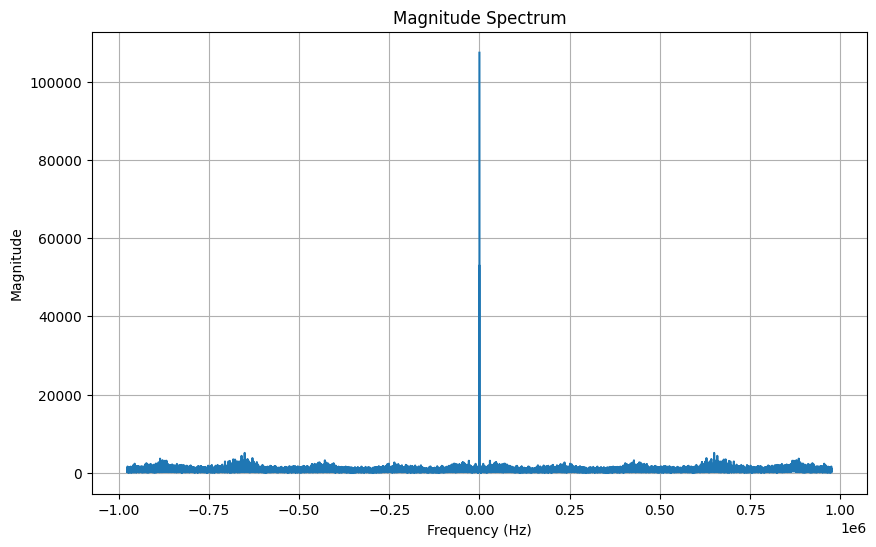

In [35]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(fft_df['Frequency'], fft_df['FFT Magnitude'])  # Plot positive frequency vs magnitude
plt.title('Magnitude Spectrum')  # Title of the plot
plt.xlabel('Frequency (Hz)')  # Label for the x-axis
plt.ylabel('Magnitude')  # Label for the y-axis
plt.grid(True)  # Show grid for better readability
plt.show()  # Display the plot

# Saving to numpy array

In [36]:
numpy_array = fft_df.to_numpy()
# Save the array to a file
#np.save('source_code/Data/Processed/Emptyseat_npy_array_Lowpassfiltered_label.npy', numpy_array)

# Define save path (2 levels up → Data/Processed/)
save_path = os.path.join("..", "..", "Data", "Processed", 
                         "Emptyseat_npy_array_Lowpassfiltered_label.npy")

# If file already exists, remove it
if os.path.exists(save_path):
    os.remove(save_path)
    print(f"Old file removed: {save_path}")

# Save the array to that location
np.save(save_path, numpy_array)

print(f"New file saved at: {os.path.abspath(save_path)}")

Old file removed: ../../Data/Processed/Emptyseat_npy_array_Lowpassfiltered_label.npy
New file saved at: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Data/Processed/Emptyseat_npy_array_Lowpassfiltered_label.npy


In [37]:
import gc
gc.collect()

3445

In [38]:
%reset -f